# 6. Modelling
The purpose of this notebook is to create various models and try and determine which one works best for the project task. As well as trying various models, I will also experiment with different features and perform feature engineering to try and get the best predictors. As I go through this process I will try and explore the data further and continue with EDA while in the process since it is an iterative process
In this chapter I am going to build machine learning models to help us classify whether pumps in Tanzania are function, not function or functioning and needs repair. This is a ternary problem meaning we have three target classes

In [174]:
#importing necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import accuracy_score, auc, f1_score,  classification_report
import warnings
warnings.filterwarnings("ignore")
from Metricsfunction import metrics, plot_matrix


ImportError: cannot import name 'plot_matrix' from 'Metricsfunction' (/home/ezra_analytics/Desktop/Moringa_projects/Classification-model/Metricsfunction.py)

In [138]:
#reading our data
modelling_data = pd.read_csv("modelling_data.csv")
#printing the first five rows
modelling_data.head()

,status_group,amount_tsh,gps_height,longitude,latitude,basin,region,lga,population,extraction_type_group,...,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,installer,permit,public_meeting
0,functional,50.0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,Ludewa,109,gravity,...,user-group,annually,soft,enough,spring,groundwater,communal standpipe,Roman,False,True
1,functional,0.0,1399,34.698766,-2.147466,Lake Victoria,Mara,Serengeti,280,gravity,...,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,GRUMETI,True,True
2,functional,25.0,686,37.460664,-3.821329,Pangani,Manyara,Simanjiro,250,gravity,...,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,World vision,True,True
3,non functional,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,Nanyumbu,58,submersible,...,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,UNICEF,True,True
4,functional,0.0,0,31.130847,-1.825359,Lake Victoria,Kagera,Karagwe,0,gravity,...,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,Artisan,True,True


Summary statistics our our numerical columns

In [139]:
#summary statistics
modelling_data.describe()

,amount_tsh,gps_height,longitude,latitude,population
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000
mean,12.748566,668.297239,34.077427,-5.706033e+00,179.909983
std,20.976109,693.116350,6.567432,2.946019e+00,471.482176
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,25.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,215.000000
max,50.000000,2770.000000,40.345193,-2.000000e-08,30500.000000


I will  now select our target and the features from our data set so we can start building our models. Our target column is "status_group" and the other columns will be our features. We will also create a label encoder mapper to transform our target classes into 0,1 and 2

In [140]:
#label encoding
modelling_data["status_group"].replace({"functional": 0, "non functional": 1, "functional needs repair": 2}, inplace= True)
#selecting target
y = modelling_data["status_group"]
#selecting features
X = modelling_data.select_dtypes(["float", "int"])
X = X.drop("status_group", axis= 1)



We will need to to normalize all features into a consistent scale of 0 to 1 since classification models only choose from  0 or 1 especially for numeric features. After that we will split the data into train and test splits so we can train evaluate and test our model. Since this is a ternary classification we will split our data into three sets; train, validate and test. Train will take 70% of the data while validate and train will take 15 % each.

In [141]:
#splitting data into train and combine(val and test)
X_train, X_combined, y_train, y_combined = train_test_split(X, y, train_size= 0.7, random_state= 1)
#splitting combined into validate and test
X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, train_size= 0.5, random_state= 1)

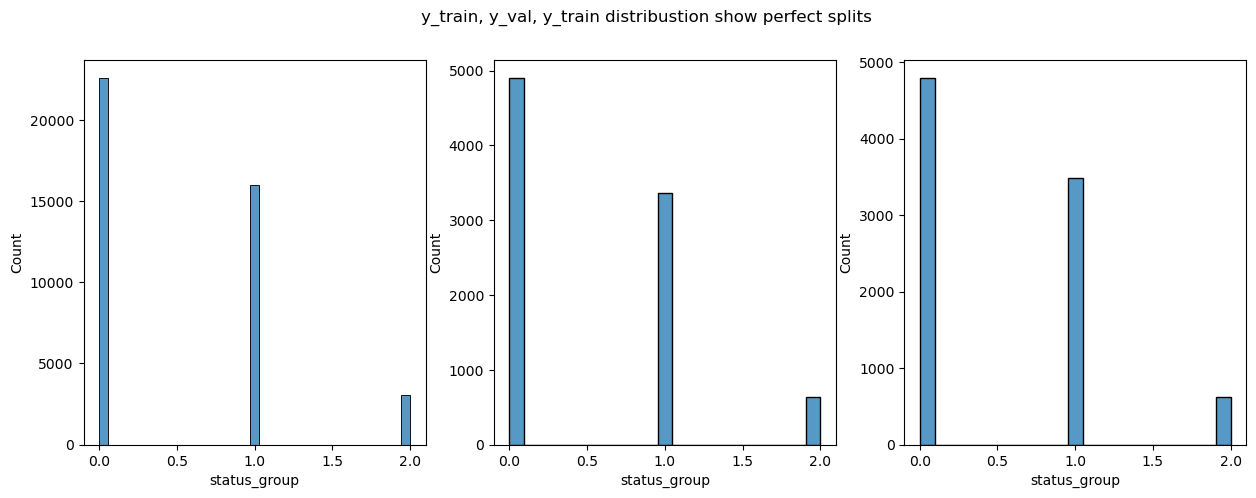

In [142]:
fig, ax = plt.subplots(ncols= 3, figsize= (15, 5))
sns.histplot(x =y_train, ax = ax[0])
sns.histplot(y_val, ax = ax[1])
sns.histplot(y_test, ax = ax[2])
plt.suptitle("y_train, y_val, y_train distribustion show perfect splits")
plt.show();


Normalizing our data and OneHotEncoding our target column using a pipeline. We use pipelines to ensure flow in our work and to avoid data leakage in our process

In [143]:
#normalizing using StandardScaler()
scaler_pipeline =  Pipeline(steps= [("scaler", StandardScaler())])
#onehotencoding our categorical column
ohe_pipeline = Pipeline(steps=[("ohe", OneHotEncoder(drop= "first"))])
#creating a transformer
transformer = ColumnTransformer(transformers= [
                                ("scaler", scaler_pipeline, [0, 1, 2, 3, 4])],remainder= "passthrough")

## 6.1 Vanilla LogisticRegression Model.
This a pure logistic regression classification model with no tuning.

In [161]:
#logistic regression pipeline
logistic_pipeline = Pipeline(steps= [
                        ("transformer", transformer),
                        ("logreg", LogisticRegression(max_iter= 200, random_state= 42))
                                ])
#fit our data
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4])])),
                ('logreg', LogisticRegression(max_iter=200, random_state=42))])

In [162]:
#X_train prediction
train_pred = logistic_pipeline.predict(X_train)
#getting the train metrics
metrics(y_train, train_pred)


              precision    recall  f1-score   support

           0       0.59      0.81      0.68     22568
           1       0.53      0.34      0.42     15965
           2       0.00      0.00      0.00      3047

    accuracy                           0.57     41580
   macro avg       0.37      0.39      0.37     41580
weighted avg       0.52      0.57      0.53     41580

---------------------------------------------------


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [166]:
matrix_plot(y_train, train_pred, logistic_pipeline)

TypeError: confusion_matrix() missing 1 required positional argument: 'model'

In [156]:
#validating our model
val_pred = logistic_pipeline.predict(X_val)


In [90]:
#testing our model
test_pred = logistic_pipeline.predict(X_test)


0.5725028058361392

Our vanilla model has an accuracy of 57%. That is not a bad score for a baseline model meaning that our model is capturing the data well considering that we have not accounted for class imbalance.
I will go ahead and plot a Logistic regressor that accounts for our class imbalance

## 6.2 LogisticRegressionCV
This is a tuned logistic regression model that searches for the best regularization parameter using cross validation. Remember that our target class is also imbalanced and that can make the model favour the most appearing  class. I will sort the class imbalance using weights that are inversely proportional to our class frequencies. I will just just pass the argument "balanced" to class weight paramater.

In [91]:
#building LogisticRegressionCV with balanced classes
logistic_pipeline = Pipeline(steps= [
                                    ("transformer", transformer),
                                    ("logregCV", LogisticRegressionCV(max_iter= 100, cv= 5, random_state=1, class_weight= "balanced"))])
#fit the data
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4])])),
                ('logregCV',
                 LogisticRegressionCV(class_weight='balanced', cv=5,
                                      random_state=1))])

Fitting our model and getting the score of our model

In [92]:

#train score
logistic_pipeline.score(X_train, y_train)

0.5235209235209235

Validating our model and obtaining the validation score

In [93]:
#fit X_val
val_pred = logistic_pipeline.predict(X_val)
#val score
accuracy_score(y_val, val_pred)

0.5208754208754208

Finally we will test our model and also obtain the test score

In [94]:
#fit the data
test_pred = logistic_pipeline.predict(X_test)
#test score
accuracy_score(y_test, test_pred)

0.5164983164983165

In [95]:
def metrics(model, X, y):
    print(f"The score is: {model.score(X, y)}")
pass
    

## 6.3 DecisionTreeClassifier

This classifier performs a recursive partition of the sample space efficiently as possible into sets with similar data points until you get close to a homogenous set and can reasonably predict the value for the new data points.
I am going to build a basic tree to see how it performs on how data before tuning it again to see if it improves or not. I will also add extra categorical features to the model since I have been using only numerical columns in my initial model. I will use pipelines here. I will drop the columns that i dont need first.

In [96]:
#dropping columns we don't need
X_new = modelling_data.drop(["status_group", "basin", "region", "lga", "management", "source_class", "installer"], axis = 1)


In [97]:
#performing train, validate, test split for our new added features
X_train, X_combined, y_train, y_combined = train_test_split(X_new, y, train_size= 0.7, random_state=1, stratify= y)
#val and test split
X_val, X_test, y_val, y_test = train_test_split(X_combined, y_combined, train_size= 0.5, random_state=1, stratify= y_combined)

In [98]:
#using pipeline to encode and fit our model
#scaling or numerical columns and encoding categorical columns
transformer2 = ColumnTransformer(transformers= [
                                ("scaler", scaler_pipeline, [0, 1, 2, 3, 4]),
                                ("ohe", ohe_pipeline, [5, 6, 7, 8, 9, 10, 11, 12, 13])], remainder= "passthrough")

In [99]:
tree_pipeline = Pipeline(steps = [
                        ("transformer2", transformer2),
                        ("tree_clf", DecisionTreeClassifier(class_weight= "balanced"))
])
#fitting our train values
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4]),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13])])),
                ('tree_clf', DecisionTreeClassifier(class_weight='balanced'))])

In [100]:
#train score and accuracy
tree_pipeline.score(X_train, y_train)

0.9934583934583935

In [101]:
#fit our validation set and see the score
val_pred = tree_pipeline.predict(X_val)
#validation score
accuracy_score(y_val, val_pred)

0.754320987654321

In [102]:
#fit our test set
test_pred = tree_pipeline.predict(X_test)
#test score
accuracy_score(y_test, test_pred)

0.7457912457912458

Wow! Our decision tree classifier seems to be working better with a score of 74% on the test set than our previous cross-validation regressor which had a score of 51%. The tree performs badly on the unseen data as we can see that it has a score of almost 100% on the train data but has a score of 75% on the validate and test data. In short the model gives a good prediction on the training data but when given unseen or new data it fails badly.
We will tune our tree and see if we can improve its performance on unseen data by finding the best prunning values

### Hyperparameter tuned DecisionTree 
I am going to tune my model hyperparameyters such as "max_depth", "min_sample_leaf" among others. I am going to see if this will improve my model performance. It is often referred to as to as the hyperparameter space for the optimum values. I'll use, Combinatoric Grid Searching, ehich is probably the most popular because it performs an exhaustive search of all possible combinations. Grid Search works by training a model on the data for each unique combination of parameters and then returning the parameters of the model that performed best. To protect us from randomness, I will use K-Fold cross-validation during this step. 

In [103]:
#creating dictionary grid
param_grid = {
                "tree_clf__min_samples_split": [2, 3, 4, 5, 6],
                "tree_clf__min_samples_leaf": [1, 2, 3, 4, 5],
                "tree_clf__criterion": ["gini", "entropy"]}
#instantiate GridSearchCV
grid = GridSearchCV(tree_pipeline , param_grid,
                    cv=3, return_train_score= True)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4]),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         [5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13])])),
                                       ('tree_clf',
                                        DecisionTreeClassifier(class_weight='balanced'))]),
             param_grid={'tree_clf__criterion': ['gini', 'entropy'],
                         'tree_clf__min_samples_leaf': [1, 2, 3, 4, 5],
                         'tree_clf__min_samples_split': [2, 3, 4, 5, 6]},
             return_train_score=True)

In [104]:
#score
print(grid.score(X_train, y_train))
print(grid.best_params_)

0.9934583934583935
{'tree_clf__criterion': 'gini', 'tree_clf__min_samples_leaf': 1, 'tree_clf__min_samples_split': 2}


In [105]:
#fit the validation set
val_pred = grid.predict(X_val)
#score
print(accuracy_score(y_val, val_pred))
print(grid.best_params_)

0.7565656565656566
{'tree_clf__criterion': 'gini', 'tree_clf__min_samples_leaf': 1, 'tree_clf__min_samples_split': 2}


In [106]:
#fit the test set
test_pred = grid.predict(X_test)
#test score
print(accuracy_score(y_test, test_pred))
print(grid.best_params_)

0.7451178451178451
{'tree_clf__criterion': 'gini', 'tree_clf__min_samples_leaf': 1, 'tree_clf__min_samples_split': 2}


After iterating over a sample space of hyperparameter tuning, our model has improved on its performance. Its score has increased 76% and biase tradeoff between the train score and the test score has also reduced significantly. This indicates that our model tuning is working and improves our model.
I will go ahead and use ensemble methods to boost our accuracy further. This an iterative process also that entails tuning of models to achieve the optimal score

## 6.4 RandomForest
This is an upgrade of DecisionTree classifier which uses greedy algorithm to maximize information gain at every step.

In [107]:
#instantiating RandomForest 
forest_pipeline = Pipeline(steps= [
                        ("transformer2", transformer2),
                        ("rf", RandomForestClassifier(class_weight= "balanced"))
])
#fit train set
forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4]),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13])])),
                ('rf', RandomForestClassifier(class_weight='balanced'))])

In [108]:
# score
forest_pipeline.score(X_train, y_train)


0.9933862433862434

In [109]:
#predicting y_val
val_pred = forest_pipeline.predict(X_val)
#score
accuracy_score(y_val, val_pred)


0.795959595959596

In [110]:
#predicting y_test
test_pred = forest_pipeline.predict(X_test)
#score
accuracy_score(y_test, test_pred)

0.7877665544332211

## Tuned RandomForest
The first vanilla ensemble method has a better score than the model before this. It is almosting achieving 80% score on the test data. It is performing poorly on unseen data as we can see the difference between the train score(99%) and test score(80) is huge. We will pass the grid search pipeline and use cross validation to see if our model will improve like in the previous models. Before that i will plot a feature importance graph to show the features our model has used most. I will write a helper function to help us with this

In [111]:
param_grid = {
                "rf__min_samples_split": [2, 4, 6],
                "rf__min_samples_leaf": [2, 3, 5],
                "rf__criterion": ["gini", "entropy"]}
#using the grid hyperparameter space
forest_grid = GridSearchCV(forest_pipeline, param_grid,
                    cv= 3, return_train_score= True)
#fit train set
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4]),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         [5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13])])),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__min_samples_leaf': [2, 3, 5],
                         'rf__min_samples_split': [2, 4, 6]},
             return_train_score=True)

In [112]:
#train score
train_pred= forest_grid.predict(X_train)
print(f"accuracy_score {accuracy_score(y_train, train_pred)}")
print(forest_grid.best_params_)

accuracy_score 0.8979076479076479
{'rf__criterion': 'gini', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2}


In [113]:
#val predict
val_pred = forest_grid.predict(X_val)
#accuracy
print(f"Validation accuracy is {accuracy_score(y_val, val_pred)}")
print(forest_grid.best_params_)

Validation accuracy is 0.7815937149270482
{'rf__criterion': 'gini', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2}


In [114]:
#test predict
test_pred = forest_grid.predict(X_test)
#accuracy
print(f"tets accuracy is {accuracy_score(y_test, test_pred)}")
print(forest_grid.best_params_)

tets accuracy is 0.7711560044893379
{'rf__criterion': 'gini', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2}


In [115]:
boosting_pipeline = Pipeline(steps= [
                            ("transformer2", transformer2),
                            ("booster", GradientBoostingClassifier())
])

In [121]:
boosting_param = {  
                    "booster__n_estimators": [1, 2, 4, 6, 7],
                    "booster__learning_rate": [1, 0.1, 0.001],
                    "booster__max_depth": [2, 3, 4, 5],
                    "booster__min_samples_split": [2,4,6],
                    "booster__min_samples_leaf": [2,3,5,6,]}

In [122]:
boosting_grid = GridSearchCV(boosting_pipeline, param_grid= boosting_param,
                            cv= 3, n_jobs= -1, return_train_score= True)
#fit train_set
boosting_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4]),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         [5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13])])),
                                       ('booster',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'booster__learning_rate': [1, 0.1, 0.001],
                         'booster__max_depth': [2, 3, 4, 5],
                         'booster__min_samples_leaf': [2, 3, 5, 6],
                         'booster__min_samples_split': [2, 4, 6],
                         'booster__n_estimators': [1, 2, 4, 6, 7]},
             return_train_score=True)

In [ ]:
#train predict
train_pred = boosting_grid.predict(X_train)

print(classification_report(y_train, train_pred))
print(boosting_grid.best_params_)

              precision    recall  f1-score   support

           0       0.74      0.91      0.81     22581
           1       0.82      0.67      0.74     15977
           2       0.63      0.21      0.31      3022

    accuracy                           0.76     41580
   macro avg       0.73      0.59      0.62     41580
weighted avg       0.76      0.76      0.75     41580

{'booster__learning_rate': 1, 'booster__max_depth': 5, 'booster__n_estimators': 6}


In [ ]:
val_pred = boosting_grid.predict(X_val)
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82      4839
           1       0.83      0.67      0.74      3424
           2       0.64      0.19      0.29       647

    accuracy                           0.77      8910
   macro avg       0.74      0.59      0.62      8910
weighted avg       0.77      0.77      0.75      8910



In [ ]:
test_pred = boosting_grid.predict(X_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      4839
           1       0.81      0.66      0.73      3423
           2       0.59      0.20      0.29       648

    accuracy                           0.76      8910
   macro avg       0.71      0.58      0.61      8910
weighted avg       0.75      0.76      0.74      8910

